In [44]:
from pydub import AudioSegment
import numpy as np
import matplotlib as plt
from decimal import Decimal

audio = AudioSegment.from_mp3("samples/Bas - Tribe with J.Cole.mp3")
samples = np.array(audio.get_array_of_samples())
samp_rate = audio.frame_rate
# audio = AudioSegment.from_mp3("samples/Bas - Tribe with J.Cole.mp3")
# samples1 = np.array(audio.get_array_of_samples())
# samples,len(samples),samples1,len(samples1)


# trimmed = np.where(samples != 0)[0]
# trimmed = trimmed[:100]
samples.shape
# samples[400]


(22939830,)

In [23]:
%time angle = np.arange(0,500)*2*np.pi*1/500
angle
%time np.arange(0,500*2,2)*np.pi*1/500

CPU times: user 108 µs, sys: 58 µs, total: 166 µs
Wall time: 123 µs
CPU times: user 67 µs, sys: 36 µs, total: 103 µs
Wall time: 60.1 µs


array([0.        , 0.01256637, 0.02513274, 0.03769911, 0.05026548,
       0.06283185, 0.07539822, 0.08796459, 0.10053096, 0.11309734,
       0.12566371, 0.13823008, 0.15079645, 0.16336282, 0.17592919,
       0.18849556, 0.20106193, 0.2136283 , 0.22619467, 0.23876104,
       0.25132741, 0.26389378, 0.27646015, 0.28902652, 0.30159289,
       0.31415927, 0.32672564, 0.33929201, 0.35185838, 0.36442475,
       0.37699112, 0.38955749, 0.40212386, 0.41469023, 0.4272566 ,
       0.43982297, 0.45238934, 0.46495571, 0.47752208, 0.49008845,
       0.50265482, 0.5152212 , 0.52778757, 0.54035394, 0.55292031,
       0.56548668, 0.57805305, 0.59061942, 0.60318579, 0.61575216,
       0.62831853, 0.6408849 , 0.65345127, 0.66601764, 0.67858401,
       0.69115038, 0.70371675, 0.71628313, 0.7288495 , 0.74141587,
       0.75398224, 0.76654861, 0.77911498, 0.79168135, 0.80424772,
       0.81681409, 0.82938046, 0.84194683, 0.8545132 , 0.86707957,
       0.87964594, 0.89221231, 0.90477868, 0.91734505, 0.92991

$\omega$ = frequency variable  
$F[n]$ = sample $n$

# Discrete Fourier Transform
inputs: Sequence of complex pairs in the time domain
outputs: Sequence of complex pairs in the frequency domain

### Equations: 
#### DFT
$X(k)=\sum_{t=0}^{n-1}x(t)e^{-2\pi itk/n}$

#### Euler's formula:  
$e^{ix} = \cos x+i\sin x$

#### DFT+Euler's:  
$e^{-2\pi itk/n} = \cos(-2\pi tk/n) + i\sin(-2\pi tk/n)$  
$(a+bi)(c+di) = ac+adi+bi-bd$  
$ac+adi+bi-bd = ac-bd+(ad+bc)i$  
$e^{-2\pi itk/n} = \cos(2\pi tk/n) - i\sin(2\pi tk/n)$  

#### DFT-eval
Let $R(x(t)) =$ the real component of $x(t)$  
Let $I(x(t)) =$ the complex componet of $x(t)$. $I(x(t)) = 0$ for all our data.  

$X(k)=\sum_{t=0}^{n-1}[R(x(t))+I(x(t))][\cos(2\pi tk/n) - i\sin(2\pi tk/n)]$  
$X(k)=\sum_{t=0}^{n-1}x(t)[\cos(2\pi tk/n) - i\sin(2\pi tk/n)]$  
$X(k)=\sum_{t=0}^{n-1}x(t)\cos(2\pi tk/n) - ix(t)\sin(2\pi tk/n)]$  


In [42]:
def DFT(x):
    """
    Perform discrete fourier transform over input array x
    x is assumed to be real and of shape (n,1)
    
    Args
    ----
    x: Array to perform DFT over
    
    Returns
    -------
    out: Complex result of DFT, shape (n,2)
    """
    n = len(x)
    if n > 50_000:
        print("You're trying to do >50,000^2 operations. Cancelling for you, this is probably a mistake")
        return 0
    out = []
    def kstep(k:int):
        """
        Calculate the k step sum for DFT
        
        Args
        ----
        int:k - the step to calculate
        
        Return
        complex:step - the complex number result
        """        
        angle = np.arange(0,n)*2*np.pi*k/n
        r = np.sum(x*np.cos(angle))
        i = np.sum(-x*np.sin(angle))

        return r+(i*1j)
    for k in range(n):
        out.append(kstep(k))
    return out

def slicer(x,size=500,slices=None):
    """
    Given an array (x,_) split the array into 'slices' sub-arrays of length <= size
    If slices isn't provided, slices = ceil(len(x)/size). 
    
    If size isn't a factor of len(x), size will pad the last slice with 0's
    
    If slices and size are provided, slices will take precidence.
    
    For a given slices, size will become 1+len(x)//slices for all except 
    the last m slices, which will have size len(x)//slices. This is to keep the
    slice sizes consistent with each other. 
    **In practice this will be done by duplicating the last values of all m slices.**
    maybe want to just fill 0? need to experiemnt, this seems insignificant
    
    
    Args
    ----
    x: Array to slice
    size: Max size of each slice
    slices: Number of slices to slice 
    
    Return
    ------
    a: Array of shape (slices,size)
    """
    n = len(x)
    if n < size:
        print("Size too large for x")
        return np.array()
    if not slices:
        if n%size != 0:
            slices = int(np.ceil(n/size))
            padded = np.concatenate((x,np.zeros(size-(n%size))))
            # print(slices,n,n%size,n/size,len(padded),len(padded)/size)
            return np.array(np.split(padded,slices))
        return np.array(np.split(x,n//size))
    
    if slices:
        return np.array(np.array_split(x,slices))
        
# # DFT(trimmed)    
slicer(samples,size=50_000).shape #,len(trimmed)/50_000
# DFT(slicer(trimmed,size=500))
res = [DFT(arr) for arr in slicer(samples,size=1024)]
type(res[1][0])

numpy.complex128

In [37]:
res[0][0]

(1+0j)

0j <class 'numpy.complex128'> (-3.0233741e-05+0j) <class 'numpy.complex64'>


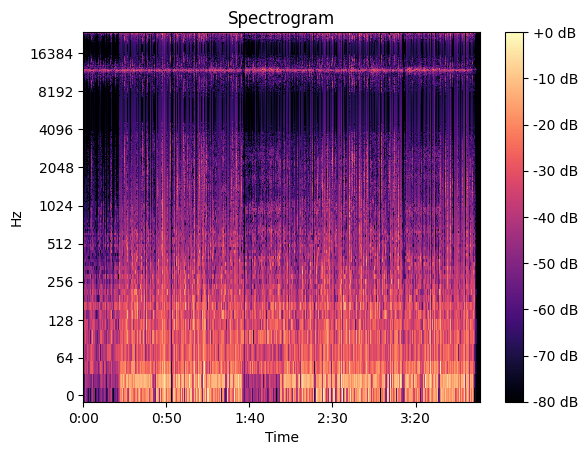

In [43]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# file_path = 'samples/sample-2.mp3'
# file_path = "samples/440Hz_44100Hz_16bit_05sec.mp3"
# y, sr = librosa.load(file_path, sr=None)

# D_ref = librosa.stft(y)
print(res[0][0],type(res[0][0]),D_ref[0][0],type(D_ref[0][0]))
mag = np.abs(res)

librosa.display.specshow(librosa.amplitude_to_db(mag.T, ref=np.max), sr=samp_rate, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()